# Pipeline for image size estimation

Imports

In [20]:
# basics
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
# file work
import os
import json
# computer vision
import cv2
import torch
import laser_detection as ld
# models
from segment_anything import sam_model_registry, SamPredictor
from easy_ViTPose import VitInference
from huggingface_hub import hf_hub_download

## Step 0: Assign input point to each image

run: 'python3 label.py' to get json of image names and input points (change path to folder in script)

## Step 1: Load image data from json

The below are modifiable variables you can change depending on what dataset you are running

In [95]:
# ALL DATA
json_file = '../data/perfect.json'  # must contain input labels
image_folder = '../data/perfect'
mask_folder = '../data/perfect_masks'  # can be empty to start

# SAMPLE DATA
# json_file = 'sample_data/red_lasers/sample_data.json'  # must contain input labels
# image_folder = 'sample_data/red_lasers/sample_data'
# mask_folder = 'sample_data/red_lasers/sample_data_masks'  # can be empty to start

# load data
with open(json_file, 'r') as file:
    image_data = json.load(file)

In [96]:
len(image_data)

72

## Step 2: Run images through SAM to prep for laser detection

### ***only need to run this code once to get masks!!!

Set up SAM

In [23]:
# select checkpoint and model type
sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

# define predictor
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# change device if cuda is available
if torch.cuda.is_available():
    sam.to(device='cuda')

predictor = SamPredictor(sam)

In [24]:
def generate_mask(im, input_point):
    input_label = np.array([1])
    predictor.set_image(im)
    masks, scores, _ = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)
    # return best mask
    return masks[np.argmax(scores)]

Iterate through images and get mask

In [25]:
from tqdm import tqdm
# iterate through each entry in the JSON data
for image_name, im_data in tqdm(image_data.items(), desc="SAM"):
    image_path = os.path.join(image_folder, image_name)
    
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # extract coordinates
    input_point = np.array([im_data['input_point']])
    # Generate the mask
    mask = generate_mask(img, input_point)
    mask = mask.astype(np.uint8)

    # Define the mask filename
    mask_filename = os.path.splitext(image_name)[0] + "_mask.png"
    mask_path = os.path.join(mask_folder, mask_filename)

    # Save the mask
    cv2.imwrite(mask_path, mask)

    # Update the JSON data with the mask filename
    image_data[image_name]['mask'] = mask_filename

SAM: 100%|██████████| 187/187 [01:54<00:00,  1.63it/s]


## Step 3: Run VitPose

In [26]:
# define model parameters
MODEL_SIZE = 'h'
YOLO_SIZE = 'n'
DATASET = 'apt36k'
ext = '.pth'
ext_yolo = '.pt'

# download model_path and yolo_path
MODEL_TYPE = "torch"
YOLO_TYPE = "torch"
REPO_ID = 'JunkyByte/easy_ViTPose'
FILENAME = os.path.join(MODEL_TYPE, 
                        f'{DATASET}/vitpose-' + MODEL_SIZE + f'-{DATASET}') + ext
FILENAME_YOLO = 'yolov8/yolov8' + YOLO_SIZE + ext_yolo
print(f'Downloading model {REPO_ID}/{FILENAME}')
model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
yolo_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME_YOLO)

In [27]:
# initialize model
model = VitInference(model_path, yolo_path, MODEL_SIZE, dataset=DATASET)

In [28]:
count = 0
# iterate through each entry in json
for image_name, info in tqdm(image_data.items(), desc="ViTPose"):
    image_path = os.path.join(image_folder, image_name)
    # load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

    # get keypoints
    img_arr = np.array(img, dtype=np.uint8)
    keypoints = model.inference(img_arr)

    if keypoints:
        # store results
        shoulder = (int(keypoints[0][3][1]), int(keypoints[0][3][0]))
        rump = (int(keypoints[0][4][1]), int(keypoints[0][4][0]))
      
        # Update the JSON data with shoulder and rump
        image_data[image_name]['shoulder_rump'] = [shoulder, rump]
    else:
        count += 1
        # TODO how do we want to handle this case in the json?
        image_data[image_name]['shoulder_rump'] = None

print(f"vitpose failed for {count} images")

ViTPose: 100%|██████████| 187/187 [00:36<00:00,  5.16it/s]

vitpose failed for 14 images


## Step 4: laser point detection

In [29]:
# Function to compute y from x using the line equation
def compute_y(x, slope, intercept):
    return int(slope * x + intercept)

# Function to create the mask with actual image dimensions
def create_geo_mask(point1, point2, image_height=1728, image_width=2592):
    # Calculate the slope and intercept of the line between the points
    dx = point2[0] - point1[0]
    dy = point2[1] - point1[1]
    slope = dy / dx if dx != 0 else None

    # Calculate the perpendicular slopes
    if slope is not None:
        perpendicular_slope = -1 / slope
        # Calculate the intercept for the perpendicular lines
        intercept1 = point1[1] - (perpendicular_slope * point1[0])
        intercept2 = point2[1] - (perpendicular_slope * point2[0])
    else:
        # If the line is vertical, the perpendiculars will be horizontal
        perpendicular_slope = 0
        intercept1 = point1[1]
        intercept2 = point2[1]

    # Create an empty mask
    mask = np.zeros((image_height, image_width), dtype=np.uint8)

    # Fill the mask
    for x in range(image_width):
        if slope is not None:
            y_from_point1 = compute_y(x, perpendicular_slope, intercept1)
            y_from_point2 = compute_y(x, perpendicular_slope, intercept2)
        else:
            # If original line is vertical, fill entire column for mask
            y_from_point1, y_from_point2 = 0, image_height - 1

        # Ensure the y values are within image boundaries
        y_from_point1 = np.clip(y_from_point1, 0, image_height - 1)
        y_from_point2 = np.clip(y_from_point2, 0, image_height - 1)

        if y_from_point1 < y_from_point2:
            mask[y_from_point1:y_from_point2, x] = 255
        else:
            mask[y_from_point2:y_from_point1, x] = 255

    return mask

In [30]:
idx = 0
# iterate through each entry in json
for image_name, info in tqdm(image_data.items(), desc="Laser Detection"):
    image_path = os.path.join(image_folder, image_name)
    # load image
    source = cv2.imread(image_path)

    # geo mask
    sr = info['shoulder_rump']
    if sr:
        point1, point2 = sr[0], sr[1]
        geo_mask = create_geo_mask(point1, point2, source.shape[0], source.shape[1])
    else:
        geo_mask = np.ones(source.shape[:2], dtype=np.uint8)

    # body mask
    mask_filename = info['mask']
    mask_path = os.path.join(mask_folder, mask_filename)
    body_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

    mask = cv2.bitwise_and(geo_mask, body_mask)
    mask = mask > 0  # need to convert to boolean values

    # adjust accodringly
    points = ld.detect_red_laser_points(source, mask)

    # Update the JSON data with the mask filename
    image_data[image_name]['laser_points'] = points

Laser Detection: 100%|██████████| 187/187 [21:57<00:00,  7.05s/it]


### Step 5: get distances

In [31]:
measured_df = pd.read_csv('../data/measured.csv')
measured_df = measured_df.dropna(subset=['PhotoID', 'Laser Width', 'BodyLength1'])

Get dictionaries for conversions

In [32]:
laser_width = dict(zip(measured_df['PhotoID'], measured_df['Laser Width']))
body_length = dict(zip(measured_df['PhotoID'], measured_df['BodyLength1']))
pix_laser = dict(zip(measured_df['PhotoID'], measured_df['PixLaser1']))
pix_length = dict(zip(measured_df['PhotoID'], measured_df['PixLength1']))

In [97]:
# iterate through each entry in json
count = 0
errors = []
# TODO
laser_errors = []
body_errors = []
ims_above_50 = []
for image_name, info in tqdm(image_data.items(), desc="Calculating Final Distances"):
    try:
        # distances in pixels
        laser_points = info['laser_points']
        body_points = info['shoulder_rump']

        # calculate ratio
        laser_dist = round(math.dist(laser_points[0], laser_points[1]), 1)
        body_dist = round(math.dist(body_points[0], body_points[1]), 1)
        ratio = laser_dist / body_dist

        # lookup laser width
        photo_id = image_name.split('.')[0]
        laser_in = laser_width[photo_id]
        # compare results
        predicted_length = laser_in / ratio
        true_length = body_length[photo_id]
        error = round(abs(predicted_length - true_length) / true_length, 3)
        errors.append(error * 100)
        print(f"Predicted: {predicted_length}\t Actual: {true_length}\t Error = {error}")
        
        if error < 0.10:
            count += 1
        elif error > 0.50:
            ims_above_50.append(image_name)
    except:
        pass

print(f"{count} / {len(image_data)} images with less than 10 percent error")

Calculating Final Distances: 100%|██████████| 72/72 [00:00<00:00, 91678.78it/s]

Predicted: 39.18151898734177	 Actual: 37.37861635	 Error = 0.048
Predicted: 63.5056519138756	 Actual: 63.20911765	 Error = 0.005
Predicted: 28.03430369787569	 Actual: 27.38267717	 Error = 0.024
Predicted: 63.86880952380952	 Actual: 62.64761905	 Error = 0.019
Predicted: 47.4812	 Actual: 47.13861386	 Error = 0.007
Predicted: 53.74196428571428	 Actual: 56.71964286	 Error = 0.052
Predicted: 38.63171171171171	 Actual: 41.86	 Error = 0.077
Predicted: 53.84967741935483	 Actual: 54.55	 Error = 0.013
Predicted: 24.887916666666666	 Actual: 26.90520833	 Error = 0.075
Predicted: 41.13166666666667	 Actual: 39.61111111	 Error = 0.038
Predicted: 41.24977139124755	 Actual: 44.34640523	 Error = 0.07
Predicted: 58.27092592592592	 Actual: 65.89074074	 Error = 0.116
Predicted: 56.627586206896545	 Actual: 60.99020979	 Error = 0.072
Predicted: 7.265899059681443	 Actual: 37.86153846	 Error = 0.808
Predicted: 177.5371900826446	 Actual: 59.07103825	 Error = 2.005
Predicted: 49.90061224489796	 Actual: 59.381818

In [98]:
print("mean:", np.mean(errors))
print("median:", np.median(errors))
print("std:", np.std(errors))

mean: 22.49264705882353
median: 5.300000000000001
std: 53.72518391881713


In [99]:
sorted(errors, reverse=True)[:8]

[307.1, 201.79999999999998, 200.5, 161.0, 87.2, 80.80000000000001, 75.9, 74.2]

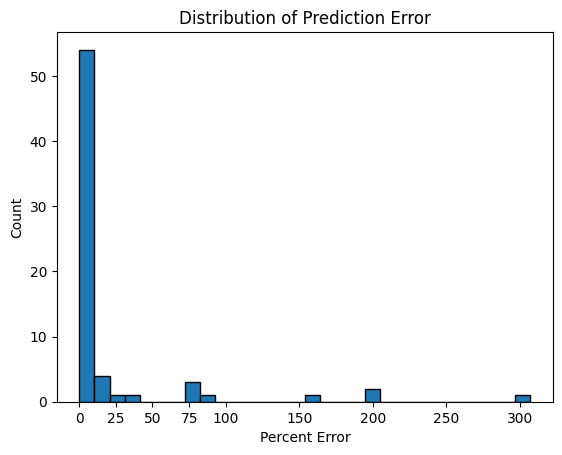

In [100]:
import matplotlib.pyplot as plt
plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel("Percent Error")
plt.xticks([0,25,50,75,100,150,200,250,300])
plt.ylabel("Count")
plt.title("Distribution of Prediction Error")
plt.show()

### Save final results

In [37]:
# Write the updated JSON data to a file
with open(json_file, 'w') as file:
    json.dump(image_data, file, indent=4)

print(f"Updated data saved to {json_file}")

Updated data saved to ../data/valid_QC.json


In [38]:
ims = ['1-Dec-2015-153.JPG',
           '23-Nov-2015-1.JPG',
           '9-Dec-2015-173.JPG',
           'KCP-20180618-Week2-0494.jpg',
           '1-Dec-2015-155.JPG',
           '4-Dec-2015-278.JPG',
           '12-Nov-2015-28.JPG',
           '27-Jan-2016-16.JPG',
           '13-Oct-2015-140.JPG',
           '21-Oct-2015-84.JPG',
           '17-Nov-2015-111.JPG',
           '23-Nov-2015-470.JPG',
           '10-Feb-2016-269.JPG',
           '10-Feb-2016-105.JPG',
           '20-Oct-2015-24.JPG',
           '20-Nov-2015-1.JPG',
           '4-Dec-2015-207.JPG',
          ]

In [39]:
len(ims)

17

In [101]:
len(ims_above_50)

8

In [102]:
def draw_dots(points, ax, color):
    ax.scatter(points[:, 0], points[:, 1], color=color, s=25, edgecolor='black')

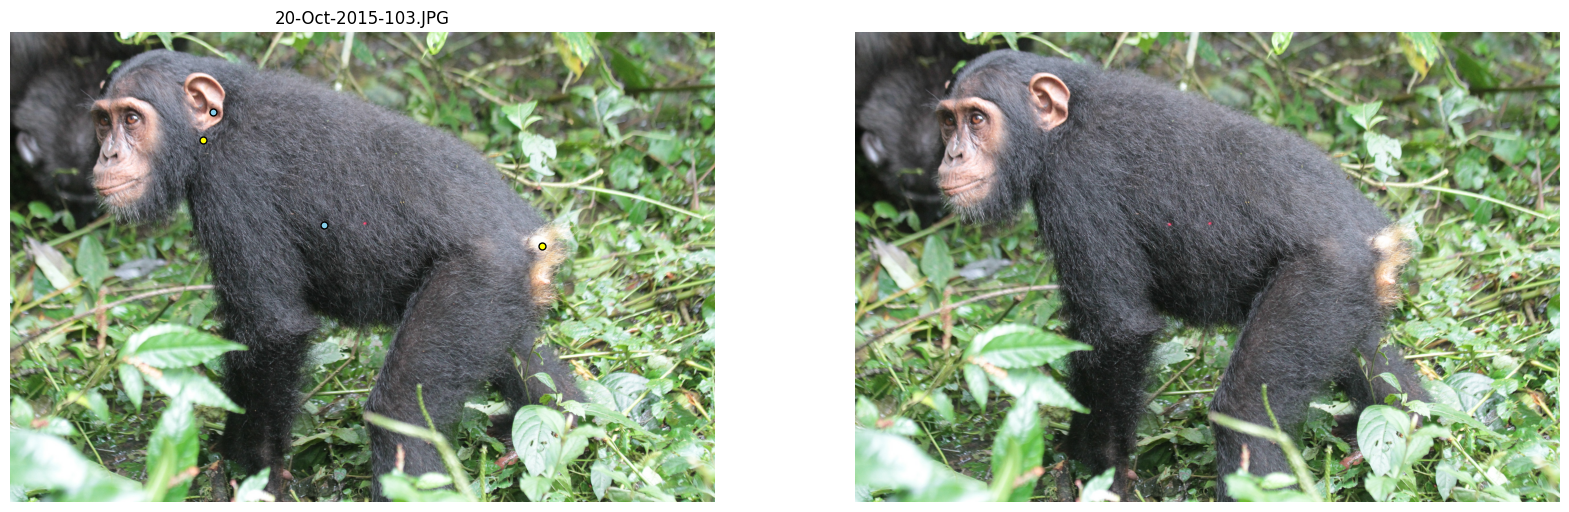

In [113]:
idx = 2
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

image_name = ims_above_50[idx]
info = image_data[image_name]

image_path = os.path.join(image_folder, image_name)
# load image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

# extract coordinates
laser_points = np.array(info['laser_points'])
body_points = np.array(info['shoulder_rump'])

# plot image
axs[0].imshow(img)
axs[1].imshow(img)

draw_dots(laser_points, axs[0], "skyblue")
draw_dots(body_points, axs[0], "yellow")
axs[0].set_title(f"{image_name}")
axs[0].axis('off')
axs[1].axis('off')

plt.show()

In [ ]:
# get specific errors for lasers vs body
